# Classification Models

**Importing required libraries**

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#import statsmodels.api as sm
#from thefuzz import process
#from thefuzz import fuzz
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve

from scipy.stats import pearsonr
from itertools import combinations


## Change below parameters to perform the required analysis

1. Add the Poverty metric:

        - Whole country:                               1
        - Urban:                                       2
        - Rural:                                       3
    

2. Data type:

        - RS +CDR:          1
        - RS only:          2
        - CDR only:         3
    

3. Model Type:

        - Random Rorest Classification:                      1
        - Shallow Decision Tree Classification:              2
        - Boosting Classification:                           3
        - Logistic Regression                                4


In [27]:

povery_metric = 1
data_type = 1
model_type = 1


# Data cleaning and Processing

In [28]:
mobile_path = '/lirneasia/data/sei_mapping/raw/mobile_features.csv'
satellite_path = '/lirneasia/data/sei_mapping/raw/satellite_features.csv'
pca_path = '/lirneasia/data/sei_mapping/raw/pca_census.csv'
urban_rural = '/lirneasia/data/sei_mapping/raw/GND_urban_rural_classification.csv'

#Reading Ground truth DATA and filtering zero population gnds (Grama niladhari divisions are referred to as gnd, which are the smallest diviions in Sri Lanka)
data_pca = pd.read_csv(pca_path)
missing_gnd_ids = data_pca.loc[data_pca['PC1'].isnull(), 'gnd_id']
count = missing_gnd_ids.count()
#print('No of gnds with zero population:',count)
# Read the datasets and merge into a single pandas dataframe
data_raw = pd.read_csv(mobile_path).merge(pd.read_csv(satellite_path), on='gnd_id').merge(pd.read_csv(pca_path), on='gnd_id').rename(columns={"PC1": "pc1"}).set_index('gnd_id')
#Removing the zero population gnds from the dataframe
data_raw = data_raw[~data_raw.index.isin(missing_gnd_ids)]

urb_rur = pd.read_csv(urban_rural)
#print(urb_rur['urbanity'].value_counts())
urban_gnds = urb_rur.loc[urb_rur['urbanity'] == 'Urban', 'gnd_id']
rural_gnds = urb_rur.loc[urb_rur['urbanity'] == 'Rural', 'gnd_id']

# Data breakdown interms of urban rural classification

if povery_metric == 1:
    pass
elif povery_metric == 2:
    data_raw = data_raw[data_raw.index.isin(urban_gnds)]
elif povery_metric == 3:
    data_raw = data_raw[data_raw.index.isin(rural_gnds)]


## Data Processing

In [29]:
# Log transform skewed variables

data_unskewed = data_raw[[

    #Call detail records
    "call_count",
    "avg_call_duration",
    "nighttime_call_count",
    "avg_nighttime_call_duration",
    "incoming_call_count",
    "avg_incoming_call_duration",
    "radius_of_gyration",
    "unique_tower_count",
    "spatial_entropy",
    "avg_call_count_per_contact",
    "avg_call_duration_per_contact",
    "contact_count",
    "social_entropy",

    #Remote Sensing data
    "travel_time_major_cities",
    "population_count_worldpop",
    "population_count_ciesin",
    "population_density",
    "aridity_index",
    "evapotranspiration",
    "nighttime_lights",
    "elevation",
    "vegetation",
    "distance_roadways_motorway",
    "distance_roadways_trunk",
    "distance_roadways_primary",
    "distance_roadways_secondary",
    "distance_roadways_tertiary",
    "distance_waterways",
    "urban_rural_fb",
    "urban_rural_ciesin",
    "global_human_settlement",
    "protected_areas",
    "land_cover_woodland",
    "land_cover_grassland",
    "land_cover_cropland",
    "land_cover_wetland",
    "land_cover_bareland",
    "land_cover_urban",
    "land_cover_water",
    "pregnancies",
    "births",
    "precipitation",
    "temperature",

    "pc1"
]].copy()

# Log transform skewed variables
data_unskewed.loc[:, "radius_of_gyration_log"] = np.log(data_unskewed["radius_of_gyration"]+ 1)
data_unskewed.loc[:, "travel_time_major_cities_log"] = np.log(data_unskewed["travel_time_major_cities"] + 1)
data_unskewed.loc[:, "population_count_worldpop_log"] = np.log(data_unskewed["population_count_worldpop"] + 1)
data_unskewed.loc[:, "population_count_ciesin_log"] = np.log(data_unskewed["population_count_ciesin"] + 1)
data_unskewed.loc[:, "population_density_log"] = np.log(data_unskewed["population_density"]+ 1)
data_unskewed.loc[:, "elevation_log"] = np.log(data_unskewed["elevation"] + 1)
data_unskewed.loc[:, "distance_roadways_trunk_log"] = np.log(data_unskewed["distance_roadways_trunk"] + 1)
data_unskewed.loc[:, "distance_roadways_primary_log"] = np.log(data_unskewed["distance_roadways_primary"] + 1)
data_unskewed.loc[:, "distance_roadways_secondary_log"] = np.log(data_unskewed["distance_roadways_secondary"] + 1)
data_unskewed.loc[:, "distance_roadways_tertiary_log"] = np.log(data_unskewed["distance_roadways_tertiary"] + 1)
data_unskewed.loc[:, "distance_waterways_log"] = np.log(data_unskewed["distance_waterways"] + 1)
data_unskewed.loc[:, "urban_rural_fb_log"] = np.log(data_unskewed["urban_rural_fb"] + 1)
data_unskewed.loc[:, "global_human_settlement_log"] = np.log(data_unskewed["global_human_settlement"] + 1)
data_unskewed.loc[:, "protected_areas_log"] = np.log(data_unskewed["protected_areas"] + 1)
data_unskewed.loc[:, "land_cover_grassland_log"] = np.log(data_unskewed["land_cover_grassland"] + 1)
data_unskewed.loc[:, "land_cover_wetland_log"] = np.log(data_unskewed["land_cover_wetland"] + 1)
data_unskewed.loc[:, "land_cover_bareland_log"] = np.log(data_unskewed["land_cover_bareland"] + 1)
data_unskewed.loc[:, "land_cover_water_log"] = np.log(data_unskewed["land_cover_water"] + 1)
data_unskewed.loc[:, "pregnancies_log"] = np.log(data_unskewed["pregnancies"]+ 1)
data_unskewed.loc[:, "births_log"] = np.log(data_unskewed["births"]+ 1)
data_unskewed.loc[:, "nighttime_lights_log"] = np.log(data_unskewed["nighttime_lights"]+ 1)


In [30]:
if data_type == 1:
    data_unskewed = data_unskewed.drop(columns=["radius_of_gyration", "travel_time_major_cities", "population_count_worldpop", "population_count_ciesin", "population_density", "elevation", "distance_roadways_trunk", "distance_roadways_primary", "distance_roadways_secondary", "distance_roadways_tertiary", "distance_waterways", "urban_rural_fb", "global_human_settlement", "protected_areas", "land_cover_grassland", "land_cover_wetland", "land_cover_bareland", "land_cover_water", "pregnancies", "births", "nighttime_lights"])

elif data_type == 2:    
    
    rs_only = data_unskewed[[
        "travel_time_major_cities_log",
        "population_count_worldpop_log",
        "population_count_ciesin_log",
        "population_density_log",
        "aridity_index",
        "evapotranspiration",
        "nighttime_lights",
        "elevation_log",
        "vegetation",
        "distance_roadways_motorway",
        "distance_roadways_trunk_log",
        "distance_roadways_primary_log",
        "distance_roadways_secondary_log",
        "distance_roadways_tertiary_log",
        "distance_waterways_log",
        "urban_rural_fb_log",
        "urban_rural_ciesin",
        "global_human_settlement_log",
        "protected_areas_log",
        "land_cover_woodland",
        "land_cover_grassland_log",
        "land_cover_cropland",
        "land_cover_wetland_log",
        "land_cover_bareland_log",
        "land_cover_urban",
        "land_cover_water_log",
        "pregnancies_log",
        "births_log",
        "precipitation",
        "temperature",

        "pc1"
    ]].copy()

    data_unskewed = rs_only.copy()

elif data_type == 3:
    
    cdr_only = data_unskewed[[
        "call_count",
            "avg_call_duration",
            "nighttime_call_count",
            "avg_nighttime_call_duration",
            "incoming_call_count",
            "avg_incoming_call_duration",
            "radius_of_gyration",
            "unique_tower_count",
            "spatial_entropy",
            "avg_call_count_per_contact",
            "avg_call_duration_per_contact",
            "contact_count",
            "social_entropy",
            "pc1" 
    ]].copy()

    data_unskewed = cdr_only.copy()

#fill missing values with their mean
data_unskewed.fillna(data_unskewed.mean(), inplace=True)
#data_unskewed.isna().sum()

data_unskewed['pc1'] = np.where(data_unskewed['pc1'] <= -3, 1, 0)

## Data stratification based on Province

In [31]:
'''
The province id is included in every gnd id's first digit 

ex: if gnd id starts with 23405....
    its corresponding province id is 2

Below data stratification is done as to represent 80 percent of gnds within a province

'''

province = data_unskewed.index.astype(str).str[0] 


#data_unskewed_eight_provinces = data_unskewed[data_unskewed.index.astype(str).str[]]

X_test = data_unskewed.drop(columns=["pc1"])
X_train = data_unskewed.drop(columns=["pc1"])
y_test = data_unskewed['pc1']
y_train = data_unskewed['pc1']
#X_train, X_test, y_train, y_test = train_test_split(data_unskewed.drop(columns=["pc1"]), data_unskewed["pc1"], stratify=province, test_size=0.3)

### Processing SL Shapefile

In [32]:
data_shapefile = gpd.read_file("/lirneasia/data/sei_mapping/sri_lanka_gnd_shape_files/sri_lanka_gnd.shp")

#In the shape file, code_7 column corresponds to the gnd id
data_shapefile.set_index("code_7", inplace=True)
data_shapefile = data_shapefile.to_crs(epsg=3857)

#total data merge with the shapefile
merged = data_unskewed.merge(data_shapefile, left_on=data_unskewed.index, right_on='code_7', how='inner')
gdf = gpd.GeoDataFrame(merged, geometry='geometry', crs=data_shapefile.crs)
gdf = gdf.to_crs(epsg=3857)
merged = merged.drop(columns=['prov_name','dist_name', 'dsd_name', 'gnd_name'])

#train set merge with the shapefile
merged_train = X_train.merge(data_shapefile, left_on=X_train.index, right_on='code_7', how='inner')
gdf_train = gpd.GeoDataFrame(merged_train, geometry='geometry', crs=data_shapefile.crs)
gdf_train = gdf_train.to_crs(epsg=3857)
merged_train = merged_train.drop(columns=['prov_name','dist_name', 'dsd_name', 'gnd_name'])

#test data merge with the shapefile
merged_test = X_test.merge(data_shapefile, left_on=X_test.index, right_on='code_7', how='inner')
gdf_test = gpd.GeoDataFrame(merged_test, geometry='geometry', crs=data_shapefile.crs)
gdf_test = gdf_test.to_crs(epsg=3857)
merged_test = merged_test.drop(columns=['prov_name','dist_name', 'dsd_name', 'gnd_name'])

## Modeling



### 1. **Random Forest Classification**

    - 500 TREES
    - 1000 TREES
    - 2000 TREES

### 2. **Shallow Decision Tree Classification**

    - 3 DEEP
    - 5 DEEP
    - 10 DEEP

### 3. **Boosting Classification**

    - XGBoost

### 4. **Logistic Regression**

In [33]:
# Feature importance
'''
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=42)
rf_classifier.fit(X_train, y_train)

importances = rf_classifier.feature_importances_
indices = np.argsort(importances)
feature_names = X_train.columns

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
#plt.title('')
plt.show()
'''

"\nrf_classifier = RandomForestClassifier(n_estimators=1000, random_state=42)\nrf_classifier.fit(X_train, y_train)\n\nimportances = rf_classifier.feature_importances_\nindices = np.argsort(importances)\nfeature_names = X_train.columns\n\n# Plot the feature importances\nplt.figure(figsize=(10, 8))\nplt.barh(range(len(indices)), importances[indices], color='b', align='center')\nplt.yticks(range(len(indices)), [feature_names[i] for i in indices])\nplt.xlabel('Relative Importance')\n#plt.title('')\nplt.show()\n"

# Model functions

In [34]:
def train_and_evaluate_dt(max_depth):

    dt_classifier = DecisionTreeClassifier(max_depth = max_depth, random_state=42)    
    dt_classifier.fit(X_train, y_train)
        
    predictions = dt_classifier.predict(X_test)
    probabi = dt_classifier.predict_proba(X_test)[:, 1]
    
    X_test['predictions'] = predictions
    X_test['pred_prob'] = probabi

    df = X_test.sort_values('pred_prob', ascending=False)
    n_label_positives = len(df[df['predictions'] == 1])
    threshold = round((len(X_test)/100)*10)
    precision = df.iloc[:threshold]['predictions'].mean()  # This is TP / (TP + FP)
    recall = df.iloc[:threshold]['predictions'].sum() / n_label_positives  # This is TP / (TP + FN)
    accuracy = accuracy_score(y_test, X_test['predictions'])
    matrix = confusion_matrix(y_test, X_test['predictions'])
    
    y_prob = dt_classifier.predict_proba(data_unskewed.drop(columns="pc1"))[:, 1]

    merged['poverty_probability'] = y_prob



    with open("output.txt", "a") as file:
        file.write(f"\nDecision Tree Classifier with max depth {max_depth}\n")
        file.write(f"Accuracy: {accuracy}\n")
        file.write(f"Precision at 10%: {precision}\n")
        file.write(f"Recall at 10%: {recall}\n")
        file.write(f"{matrix}\n")
        file.write("-" * 40 + "\n")

    
    return dt_classifier.predict(data_unskewed.drop(columns="pc1"))


def train_and_evaluate_rf(n_estimators):
    
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf_classifier.fit(X_train, y_train)
    
    predictions = rf_classifier.predict(X_test)
    probabi = rf_classifier.predict_proba(X_test)[:, 1]
    X_test['predictions'] = predictions
    X_test['pred_prob'] = probabi
    df = X_test.sort_values('pred_prob', ascending=False)
    n_label_positives = len(df[df['predictions'] == 1])
    threshold = round((len(X_test)/100)*10)
    precision = df.iloc[:threshold]['predictions'].mean()  # This is TP / (TP + FP)
    recall = df.iloc[:threshold]['predictions'].sum() / n_label_positives  # This is TP / (TP + FN)
    accuracy = accuracy_score(y_test, X_test['predictions'])
    matrix = confusion_matrix(y_test, X_test['predictions'])
    
    y_prob = rf_classifier.predict_proba(data_unskewed.drop(columns="pc1"))[:, 1]

    merged['poverty_probability'] = y_prob

    with open("output.txt", "a") as file:
        file.write(f"\nRandom Forest Classifier with estimators: {n_estimators}\n")
        file.write(f"Accuracy: {accuracy}\n")
        file.write(f"Precision at 10%: {precision}\n")
        file.write(f"Recall at 10%: {recall}\n")
        file.write(f"{matrix}\n")
        file.write("-" * 40 + "\n")

    
    return rf_classifier.predict(data_unskewed.drop(columns="pc1"))

def train_and_evaluate_xg():
    
    xgb_classifier = xgb.XGBClassifier(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1,
        random_state=42,
        n_jobs=-1
    )

    xgb_classifier.fit(X_train, y_train)

    predictions = xgb_classifier.predict(X_test)
    probabi = xgb_classifier.predict_proba(X_test)[:, 1]

    X_test['predictions'] = predictions
    X_test['pred_prob'] = probabi

    df = X_test.sort_values('pred_prob', ascending=False)
    n_label_positives = len(df[df['predictions'] == 1])
    threshold = round((len(X_test)/100)*10)
    precision = df.iloc[:threshold]['predictions'].mean()  # This is TP / (TP + FP)
    recall = df.iloc[:threshold]['predictions'].sum() / n_label_positives  # This is TP / (TP + FN)
    accuracy = accuracy_score(y_test, X_test['predictions'])
    matrix = confusion_matrix(y_test, X_test['predictions'])
    
    y_prob = xgb_classifier.predict_proba(data_unskewed.drop(columns="pc1"))[:, 1]

    merged['poverty_probability'] = y_prob

    with open("output.txt", "a") as file:
        file.write(f"\n XGBoost Classifier\n")
        file.write(f"Accuracy: {accuracy}\n")
        file.write(f"Precision at 10%: {precision}\n")
        file.write(f"Recall at 10%: {recall}\n")
        file.write(f"{matrix}\n")
        file.write("-" * 40 + "\n")

    
    return xgb_classifier.predict(data_unskewed.drop(columns="pc1"))

def train_and_evaluate_lr():

    log_reg_classifier = LogisticRegression(random_state=42, max_iter=1000)
    log_reg_classifier.fit(X_train, y_train)

    predictions = log_reg_classifier.predict(X_test)
    probabi = log_reg_classifier.predict_proba(X_test)[:, 1]

    X_test['predictions'] = predictions
    X_test['pred_prob'] = probabi
    
    df = X_test.sort_values('pred_prob', ascending=False)
    n_label_positives = len(df[df['predictions'] == 1])
    threshold = round((len(X_test)/100)*10)
    precision = df.iloc[:threshold]['predictions'].mean()  # This is TP / (TP + FP)
    recall = df.iloc[:threshold]['predictions'].sum() / n_label_positives  # This is TP / (TP + FN)
    accuracy = accuracy_score(y_test, X_test['predictions'])
    matrix = confusion_matrix(y_test, X_test['predictions'])
    
    y_prob = log_reg_classifier.predict_proba(data_unskewed.drop(columns="pc1"))[:, 1]

    merged['poverty_probability'] = y_prob

    with open("output.txt", "a") as file:
        file.write(f"\n Logistic Regression\n")
        file.write(f"Accuracy: {accuracy}\n")
        file.write(f"Precision at 10%: {precision}\n")
        file.write(f"Recall at 10%: {recall}\n")
        file.write(f"{matrix}\n")
        file.write("-" * 40 + "\n")

    
    return log_reg_classifier.predict(data_unskewed.drop(columns="pc1"))



In [35]:
if model_type == 1:
    merged['pred_ground_truth'] = train_and_evaluate_rf(1000)

elif model_type== 2:
    merged['pred_ground_truth'] = train_and_evaluate_dt(5)

elif model_type== 3:
    merged['pred_ground_truth'] = train_and_evaluate_xg()  

elif model_type== 4:
    merged['pred_ground_truth'] = train_and_evaluate_lr()

## Evaluating model performance 

### 1. Predicting poorest 100, 500, 1000, 3000 GNDS

 Using the probability that a GN division is poor, labeled as 1. This will rank the likelihood of being poor.

In [411]:
with open("output.txt", "a") as file:
    file.write('\nEvaluation on whole country')

merged = merged.merge(pd.read_csv(pca_path), left_on='code_7', right_on='gnd_id', how='inner')

def prediction_performance(A, B):
    
    B_set = set(B)
    count = 0
    
    for element in A:
        if element in B_set:
            count += 1
            
    return count

for i in (100, 500, 1000, 3000):
    merged = merged.sort_values('PC1')
    pc_top = merged.iloc[:i]
    index_values_pc = pc_top.index.values

    merged = merged.sort_values('poverty_probability', ascending=False)
    df_top = merged.iloc[:i]   
    index_values_top = df_top.index.values

    with open("output.txt", "a") as file:
        file.write(f'\nPredicting poorest {i} Gnds: {(prediction_performance(index_values_pc, index_values_top) / i )*100}\n')


with open("output.txt", "a") as file:
    file.write('Evaluation on test Set')


X_test = X_test.merge(pd.read_csv(pca_path), left_on=X_test.index, right_on='gnd_id', how='inner')

for i in (100, 500, 1000):
    
    X_test = X_test.sort_values('PC1')
    pc_top = X_test.iloc[:i]
    index_values_pc = pc_top.index.values

    X_test = X_test.sort_values('pred_prob', ascending=False)
    df_top = X_test.iloc[:i]   
    index_values_top = df_top.index.values

    with open("output.txt", "a") as file:
        file.write(f'\nPredicting poorest {i} Gnds: {(prediction_performance(index_values_pc, index_values_top) / i )*100}\n')

In [412]:
with open("output.txt", "a") as file:
    file.write('\nEvaluation on whole country')

# Read DSD-level poverty data
dsd_poverty = pd.read_csv("/Users/chanukaalgama/Library/CloudStorage/OneDrive-LIRNEasia/DAP PROJECTS/RS + CDR Poverty Mapping/Data/raw/dsd-poverty.csv")
#Read census features 
census = pd.read_csv("/Users/chanukaalgama/Library/CloudStorage/OneDrive-LIRNEasia/DAP PROJECTS/RS + CDR Poverty Mapping/Data/raw/census_features.csv", usecols=["gnd_id", "age_total"])
census = census.rename(columns={"age_total": "pop"})

data_b2 = merged[['code_7', 'PC1', 'poverty_probability']].copy()

# Merge predicted values with the census data

merged2 = data_b2.merge(census, left_on=data_b2.code_7, right_on='gnd_id', how='inner')

# Merge with data_shapefile

gnd2dsd_df = data_shapefile.drop(columns="geometry")
merged2 = merged2.merge(gnd2dsd_df, left_on=merged.code_7, right_on=gnd2dsd_df.index, how='inner')

#Taking the Gnd level predicted data to the DSD level

dsd_grouped = merged2.groupby("dsd_name").apply(lambda x: (x["poverty_probability"] * x["pop"]).sum() / x["pop"].sum()).reset_index(name="fit_wted")

# Rename the misspelled columns using FizzBuzz

dsd_grouped["dsd_name"] = dsd_grouped["dsd_name"].apply(
  lambda x: process.extractOne(x, dsd_poverty["dsd_name"], scorer=fuzz.partial_ratio)[0]
)

dsd_final = dsd_grouped.merge(dsd_poverty, on='dsd_name', how='inner')


for x in (25, 50, 100):

    predicted_list = dsd_grouped.sort_values(by="fit_wted", ascending=True)
    predicted_list = predicted_list.head(x).copy()
    predicted_list = predicted_list.dsd_name.to_list()


    hc_list = dsd_poverty.sort_values(by="headcount_index", ascending=True)
    hc_list = hc_list.head(x).copy()
    hc_list = hc_list.dsd_name.to_list()

    series_a = pd.Series(predicted_list)
    series_b = pd.Series(hc_list)


    percentage = (series_b.isin(predicted_list).sum() / len(series_b)) * 100

    with open("output.txt", "a") as file:
        file.write(f"\nThe percentage of predicting poorest {x} DSDs: {percentage}% \n")

/var/folders/qq/v15mxgl96rjgk1x2qkhfzvlh0000gn/T/ipykernel_1423/3702613009.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dsd_grouped = merged2.groupby("dsd_name").apply(lambda x: (x["poverty_probability"] * x["pop"]).sum() / x["pop"].sum()).reset_index(name="fit_wted")


# ROC Curves

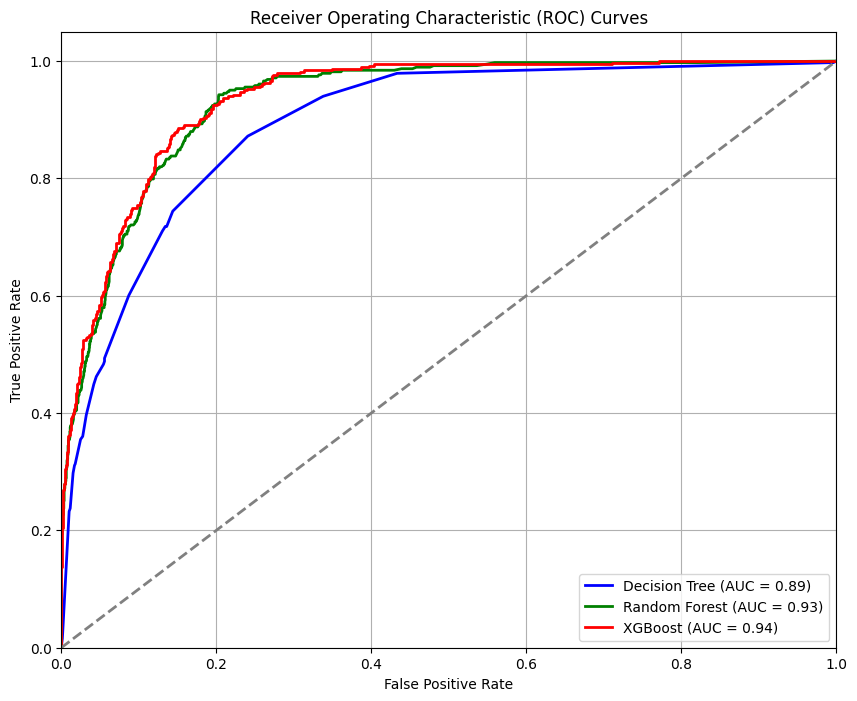

In [452]:

dt_classifier = DecisionTreeClassifier(max_depth= 5, random_state=42)    
dt_classifier.fit(X_train, y_train)
rf_classifier = RandomForestClassifier(n_estimators= 1000, random_state=42)
rf_classifier.fit(X_train, y_train)
#log_reg_classifier = LogisticRegression(random_state=42, max_iter=1000)
#log_reg_classifier.fit(X_train, y_train)

xgb_classifier = xgb.XGBClassifier(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1,
        random_state=42,
        n_jobs=-1
    )

xgb_classifier.fit(X_train, y_train)

y_pred_prob_dt = dt_classifier.predict_proba(X_test)[:, 1]
y_pred_prob_rf = rf_classifier.predict_proba(X_test)[:, 1]
y_pred_prob_xgb = xgb_classifier.predict_proba(X_test)[:, 1]
#y_pred_prob_lr = log_reg_classifier.predict_proba(X_test)[:, 1]

fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_prob_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

#fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_prob_lr)
#roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(10, 8))

plt.plot(fpr_dt, tpr_dt, color='blue', lw=2, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, color='red', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid()

plt.show()


# Precision and Recall Curves

In [36]:
df = X_test.sort_values('pc1', ascending=False)

thresholds = list(range(100, len(X_test), 100))
metrics = list()
n_label_positives = len(df[df['predictions'] == 1])

for t in thresholds:
    d = dict()
    d['threshold'] = t
    d['precision'] = df.iloc[:t]['predictions'].mean()  # This is TP / (TP + FP)
    d['recall'] = df.iloc[:t]['predictions'].sum() / n_label_positives  # This is TP / (TP + FN)

    metrics.append(d)

metrics_df = pd.DataFrame(metrics)

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['threshold'], metrics_df['precision'], label='Precision', marker='o')
plt.plot(metrics_df['threshold'], metrics_df['recall'], label='Recall', marker='o')

plt.axvline(x=2800, color='red', linestyle='--', label='Threshold = 270')
plt.xlabel('Thresholds')
plt.ylabel('Score')
plt.title('Precision and Recall Curves')
plt.legend()
plt.grid(True)
plt.show()

KeyError: 'pc1'

# Headcount index

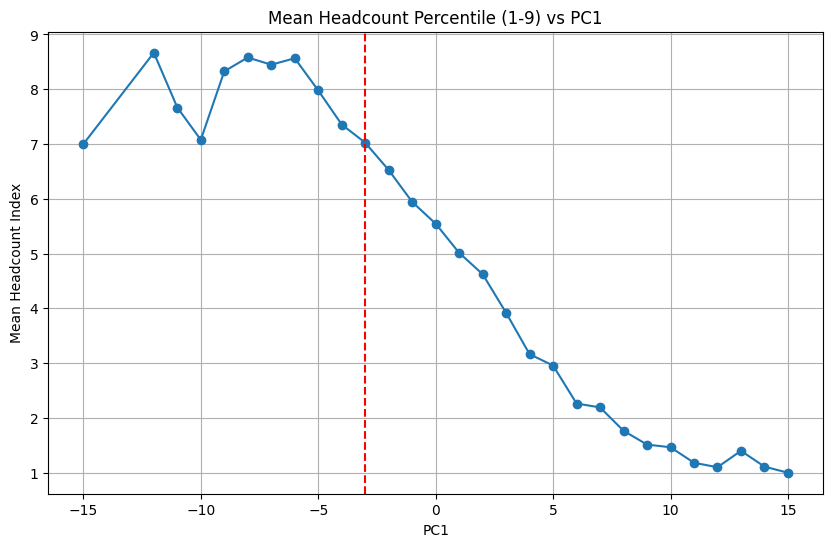

In [429]:
# DSD level poverty headcount index got from the department of census and statistics report
dsd_data = pd.read_csv('/Users/chanukaalgama/Library/CloudStorage/OneDrive-LIRNEasia/DAP PROJECTS/RS + CDR Poverty Mapping/Data/processed/dsd_headcount_index.csv')
dsd_data = dsd_data[['dsd_name', 'code_7', 'headcount_index']].copy()
# Sri lanka Shapefile

data_shapefile = gpd.read_file("/Users/chanukaalgama/Library/CloudStorage/OneDrive-LIRNEasia/DAP PROJECTS/RS + CDR Poverty Mapping/Data/sri_lanka_gnd_shape_files/sri_lanka_gnd.shp")

# Read PCA census data
census_data = pd.read_csv('/Users/chanukaalgama/Library/CloudStorage/OneDrive-LIRNEasia/DAP PROJECTS/RS + CDR Poverty Mapping/Data/raw/pca_census.csv')


def mapping_headcount(headcount):
    
    mapped_value = []
    for x in headcount:
        if x < 7:
            mapped = 1
        elif x < 14:
            mapped = 2
        elif x < 21:
            mapped = 3
        elif x < 28:
            mapped = 4
        elif x < 35:
            mapped = 5
        elif x < 42:
            mapped = 6
        else:
            mapped = 7
        mapped_value.append(mapped)
    
    return mapped_value


def mapping_pc1(pc1):
    
    mapped_value = []
    for x in pc1:
        #x = x + 15
        mapped_value.append(round(x))
    
    return mapped_value


def map_to_percentiles(column):

    mapped_value = []
    percentiles = np.percentile(column, np.arange(0, 101, 10))
    
    def percentile_mapping(value):
        for i in range(1, len(percentiles)):
            if value <= percentiles[i]:
                return i
    
    mapped_value = column.apply(percentile_mapping)
    return mapped_value


merged1 = census_data.merge(dsd_data, left_on= 'gnd_id', right_on= 'code_7', how= 'inner')

merged1.drop(columns=['code_7', 'dsd_name'])

merged1 = merged1.dropna(subset=['PC1', 'headcount_index'])

merged1['mapped_hi'] = mapping_headcount(merged1['headcount_index'])
merged1['hi_percentiles'] = map_to_percentiles(merged1['headcount_index'])
merged1['mapped_pc1'] = mapping_pc1(merged1['PC1'])

mean_headcount_index = merged1.groupby('mapped_pc1')['hi_percentiles'].mean().reset_index()


plt.figure(figsize=(10, 6))
plt.plot(mean_headcount_index['mapped_pc1'], mean_headcount_index['hi_percentiles'], marker='o')
plt.title('Mean Headcount Percentile (1-9) vs PC1')
plt.axvline(x=-3, color='red', linestyle='--', label='Poverty Threshold')
plt.xlabel('PC1')
plt.ylabel('Mean Headcount Index')
plt.grid(True)
plt.show()


In [724]:
#bgm = pd.read_csv('/Users/chanukaalgama/Library/CloudStorage/OneDrive-LIRNEasia/DAP PROJECTS/RS + CDR Poverty Mapping/Data/processed/bayesian/bayesian_results_final.csv')
#bgm = bgm[['pred_values', 'gnd_id']].copy()
#merged1 = merged1[['gnd_id', 'PC1', 'headcount_index', 'hi_percentiles']].copy()
#bgm = bgm[['pred_values', 'gnd_id']].copy()
#bgm = bgm.merge(merged1, left_on= 'gnd_id', right_on= merged1.gnd_id, how= 'inner')
#X_test1['pred_prob'] = X_test1['pred_prob'].round(1)
#bgm.to_csv('bgm_full.csv')

In [701]:
#merged1 = merged1[['gnd_id', 'PC1', 'headcount_index', 'hi_percentiles']].copy()
X_test1 = X_test[['predictions', 'pred_prob']].copy()
X_test1 = X_test1.merge(merged1, left_on= X_test1.index, right_on= 'gnd_id', how= 'inner')
X_test1['pred_prob'] = X_test1['pred_prob'].round(1)
X_test1.to_csv('dt_full.csv')

In [450]:
rf = pd.read_csv('rf_full.csv')
dt = pd.read_csv('dt_full.csv')
xg = pd.read_csv('xg_full.csv')
base1 = pd.read_csv('base2.csv')
bgm = pd.read_csv('bgm_full.csv')

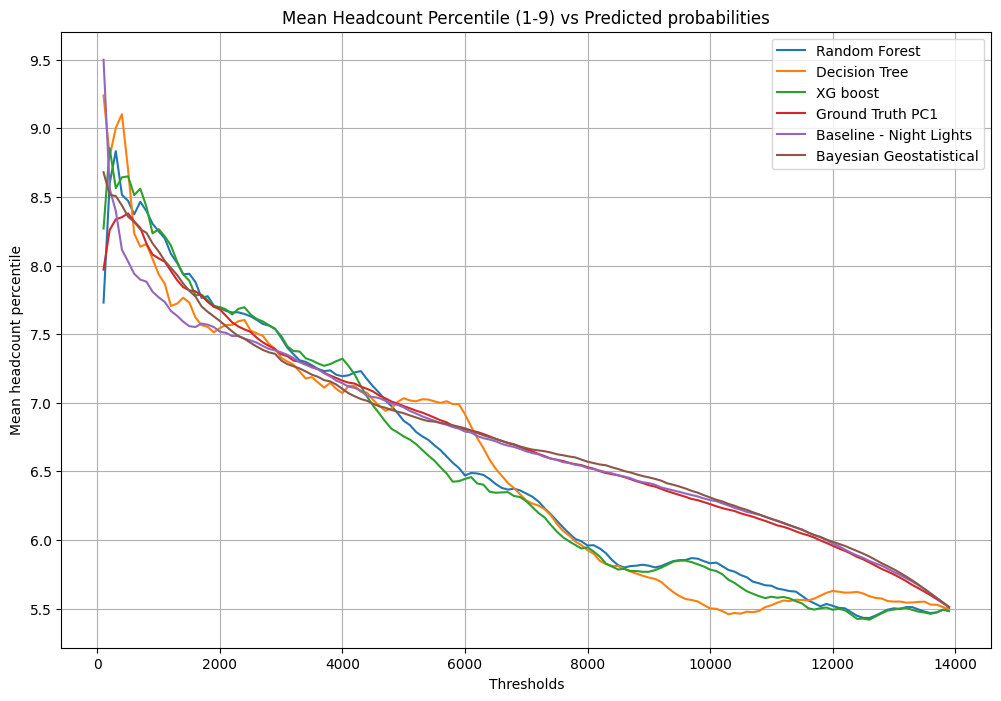

In [451]:
def calculate_metrics(df, column_name, ascending=False):
    df_sorted = df.sort_values(column_name, ascending=ascending)
    metrics = [
        {
            'threshold': t,
            'pred_prob_mean': df_sorted.iloc[:t]['hi_percentiles'].mean()
        }
        for t in thresholds
    ]
    return pd.DataFrame(metrics)

models = [
    ('Random Forest', rf, 'pred_prob', False),
    ('Decision Tree', dt, 'pred_prob', False),
    ('XG boost', xg, 'pred_prob', False),
    ('Ground Truth PC1', rf, 'PC1', True),
    ('Baseline - Night Lights', base1, 'nighttime_lights_log', True),
    ('Baseline - Pop Density', base1, 'population_density_log', True),
    ('Bayesian Geostatistical', bgm, 'pred_values', True)
]

thresholds = list(range(100, len(rf), 100))
metrics_dfs = {name: calculate_metrics(df, col, asc) for name, df, col, asc in models}

combined_df = pd.DataFrame({'threshold': thresholds})
for name, metrics_df in metrics_dfs.items():
    combined_df[f'{name}_pred_prob_mean'] = metrics_df['pred_prob_mean']

plt.figure(figsize=(12, 8))

for name in metrics_dfs.keys():
    if name != 'Baseline - Pop Density':  # Exclude this one as per original code
        plt.plot(combined_df['threshold'], combined_df[f'{name}_pred_prob_mean'], label=name)

plt.xlabel('Thresholds')
plt.ylabel('Mean headcount percentile')
plt.title('Mean Headcount Percentile (1-9) vs Predicted probabilities')
plt.legend()
plt.grid(True)
plt.show()

#plt.savefif(dpi = 3000)

#combined_df.to_csv('combined_metrics.csv', index=False)

In [452]:
from scipy.stats import pearsonr

def calculate_rank_correlation(df, models, thresholds):
    rank_corrs = []
    
    for t in thresholds:
        for i, (name1, df1, col1, asc1) in enumerate(models):
            for j, (name2, df2, col2, asc2) in enumerate(models):
                if i < j:
                    df1_sorted = df1.sort_values(col1, ascending=asc1).iloc[:t]
                    df2_sorted = df2.sort_values(col2, ascending=asc2).iloc[:t]
                    
                    corr, _ = pearsonr(df1_sorted['gnd_id'], df2_sorted['gnd_id'])
                    
                    overlap = len(set(df1_sorted.gnd_id).intersection(set(df2_sorted.gnd_id))) / t
                    
                    rank_corrs.append({
                        'threshold': t,
                        'model1': name1,
                        'model2': name2,
                        'pearson_correlation': corr,
                        'overlap': overlap
                    })
    
    return pd.DataFrame(rank_corrs)

thresholds = list(range(100, len(rf), 100))
models = [
    ('Random Forest', rf, 'pred_prob', False),
    ('Decision Tree', dt, 'pred_prob', False),
    ('XG boost', xg, 'pred_prob', False),
    ('Ground Truth PC1', rf, 'PC1', True),
    ('Baseline - Night Lights', base1, 'nighttime_lights_log', True),
    ('Baseline - Pop Density', base1, 'population_density_log', True),
    ('Bayesian Geostatistical', bgm, 'pred_values', True)
]

rank_corr_df = calculate_rank_correlation(combined_df, models, thresholds)

#print(rank_corr_df.head())


In [453]:
msk = (rank_corr_df['model1'] == 'Ground Truth PC1') | (rank_corr_df['model2'] == 'Ground Truth PC1')

#rank_corr_df['msk'] = msk

pc1 = rank_corr_df[msk]

pc1['comparison'] = pc1.apply(lambda x: x['model2'] if x['model1'] == 'Ground Truth PC1' else x['model1'], axis=1)


/var/folders/qq/v15mxgl96rjgk1x2qkhfzvlh0000gn/T/ipykernel_10980/3880990827.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pc1['comparison'] = pc1.apply(lambda x: x['model2'] if x['model1'] == 'Ground Truth PC1' else x['model1'], axis=1)


Text(0.5, 1.0, 'Rank Correlation between ML models-based and the PC1-based rankings')

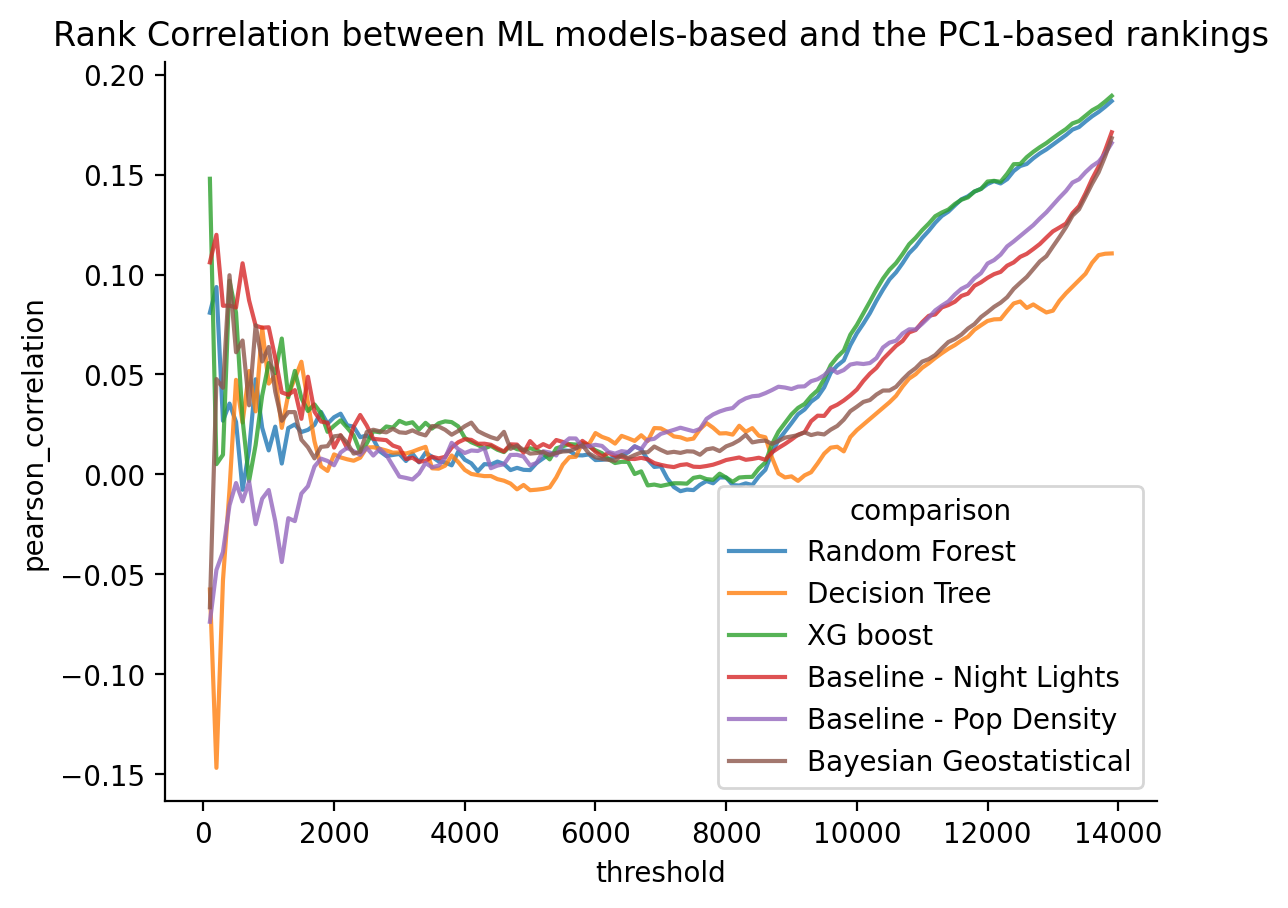

In [455]:
fig, ax = plt.subplots(dpi=200)

sn.lineplot(
    data=pc1,
    x='threshold',
    y='pearson_correlation',
    hue='comparison',
    ax=ax,
    alpha=0.8
)

# ax.set_xlim(0, )
sn.despine()
ax.set_title('Rank Correlation between ML models-based and the PC1-based rankings')


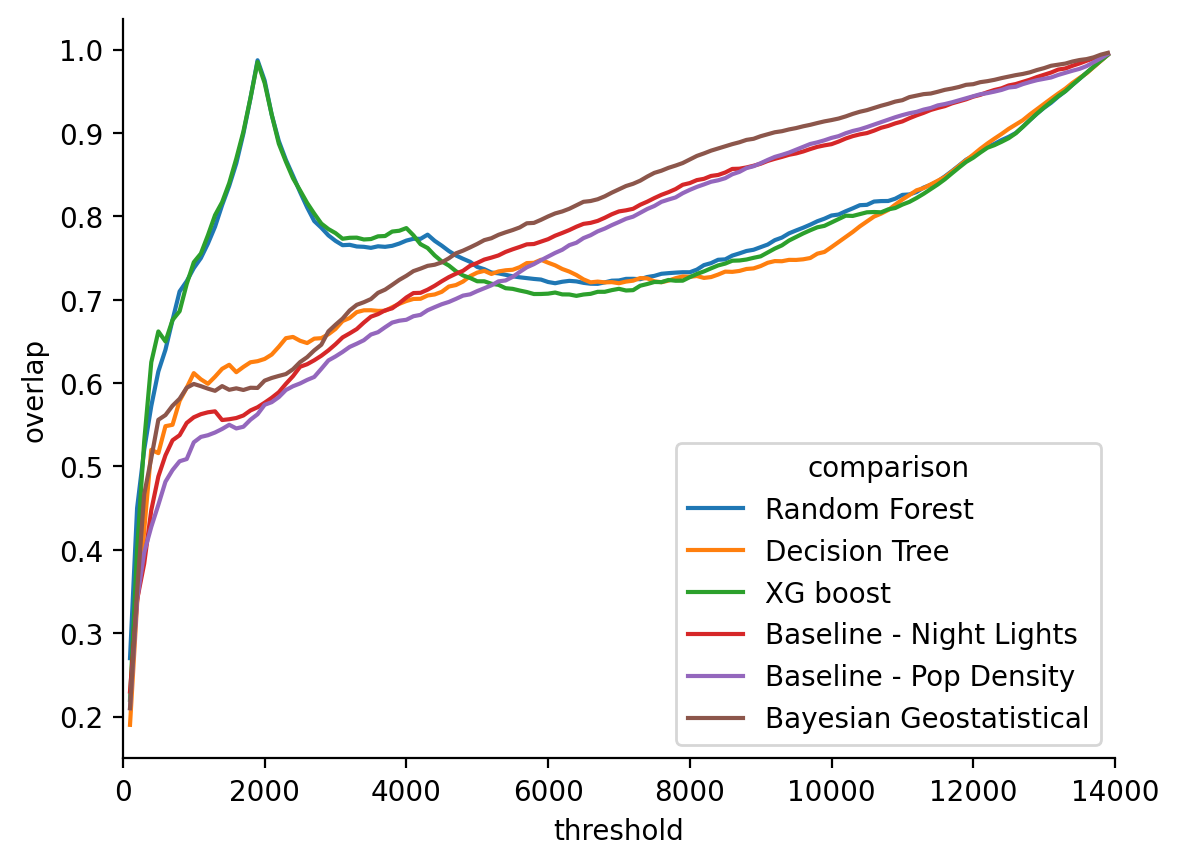

In [456]:
fig, ax = plt.subplots(dpi=200)

sn.lineplot(
    data=pc1,
    x='threshold',
    y='overlap',
    hue='comparison',
    ax=ax
)
ax.set_xlim(0, 14000)
sn.despine()
#ax.set_title('')


Text(0.5, 1.0, '')

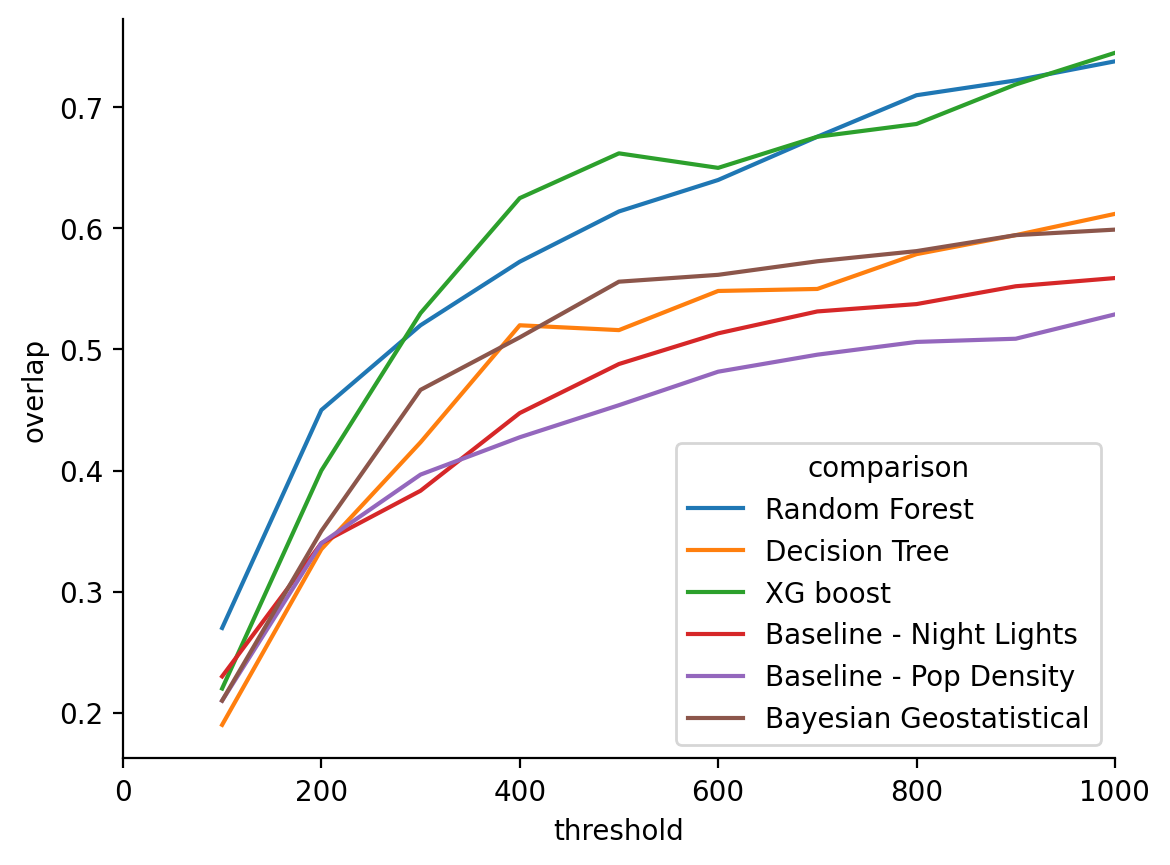

In [458]:
pc1_1000 = pc1[pc1['threshold'] <= 1000]


fig, ax = plt.subplots(dpi=200)

sn.lineplot(
    data=pc1_1000,
    x='threshold',
    y='overlap',
    hue='comparison',
    ax=ax
)
ax.set_xlim(0, 1000)
sn.despine()
ax.set_title('')


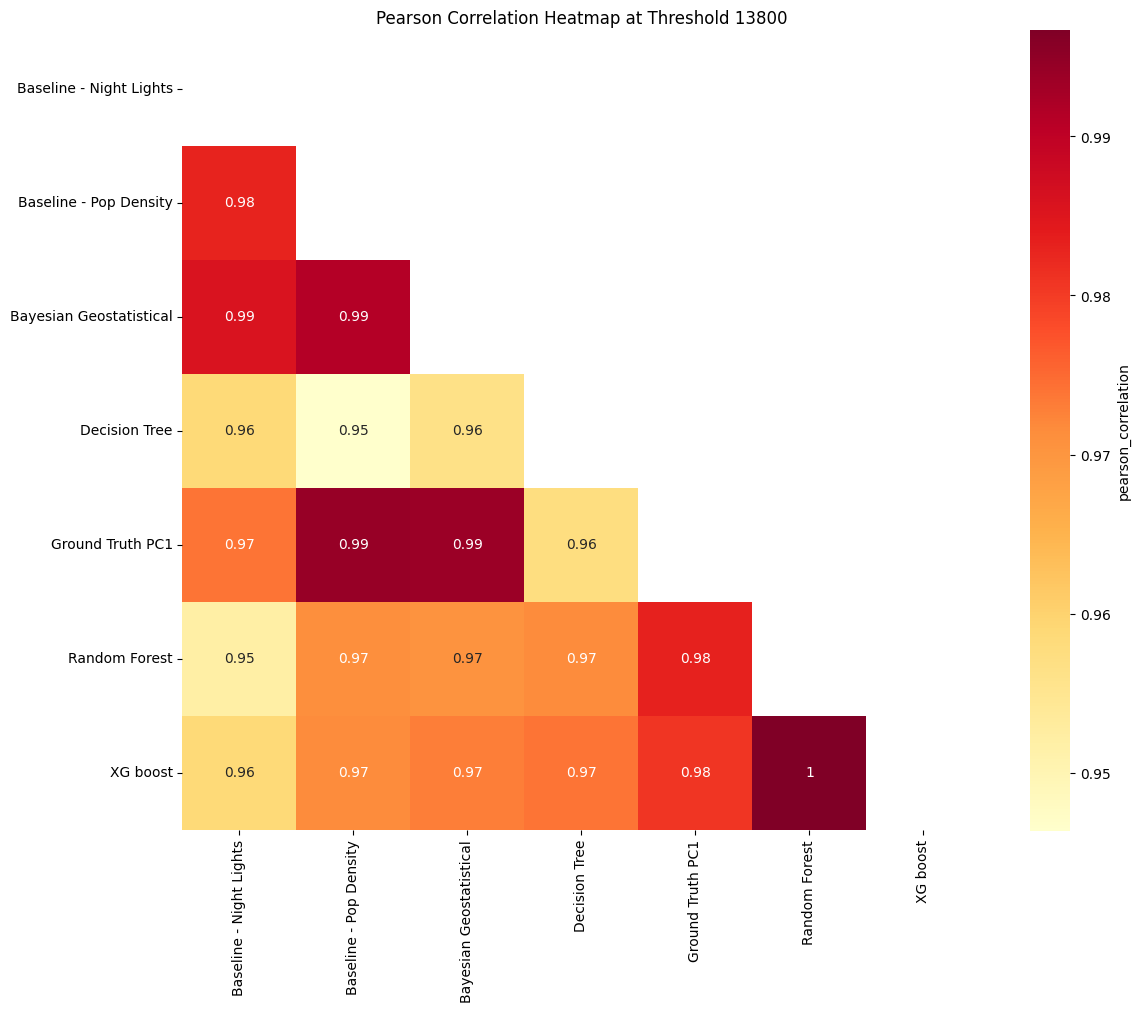

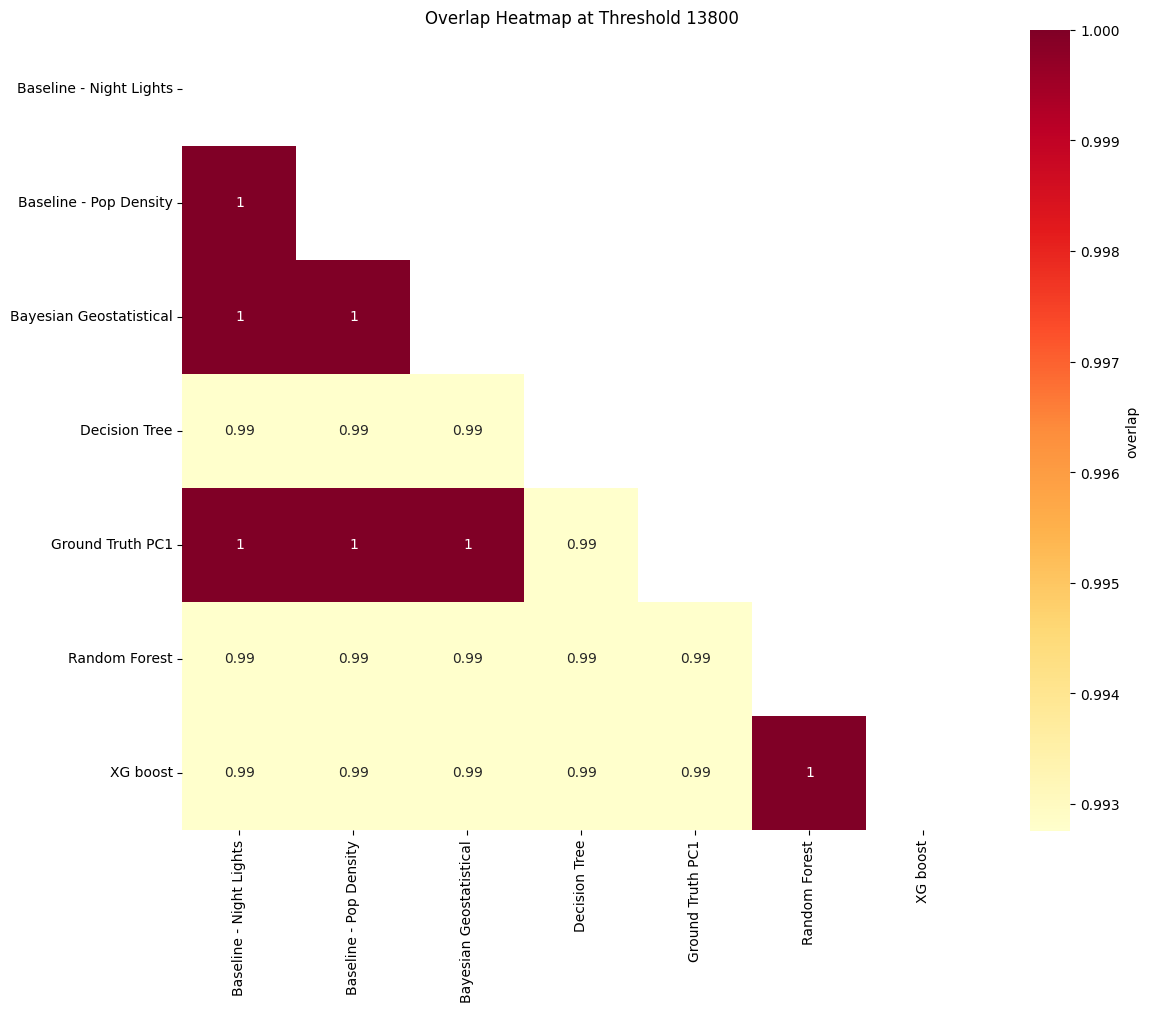

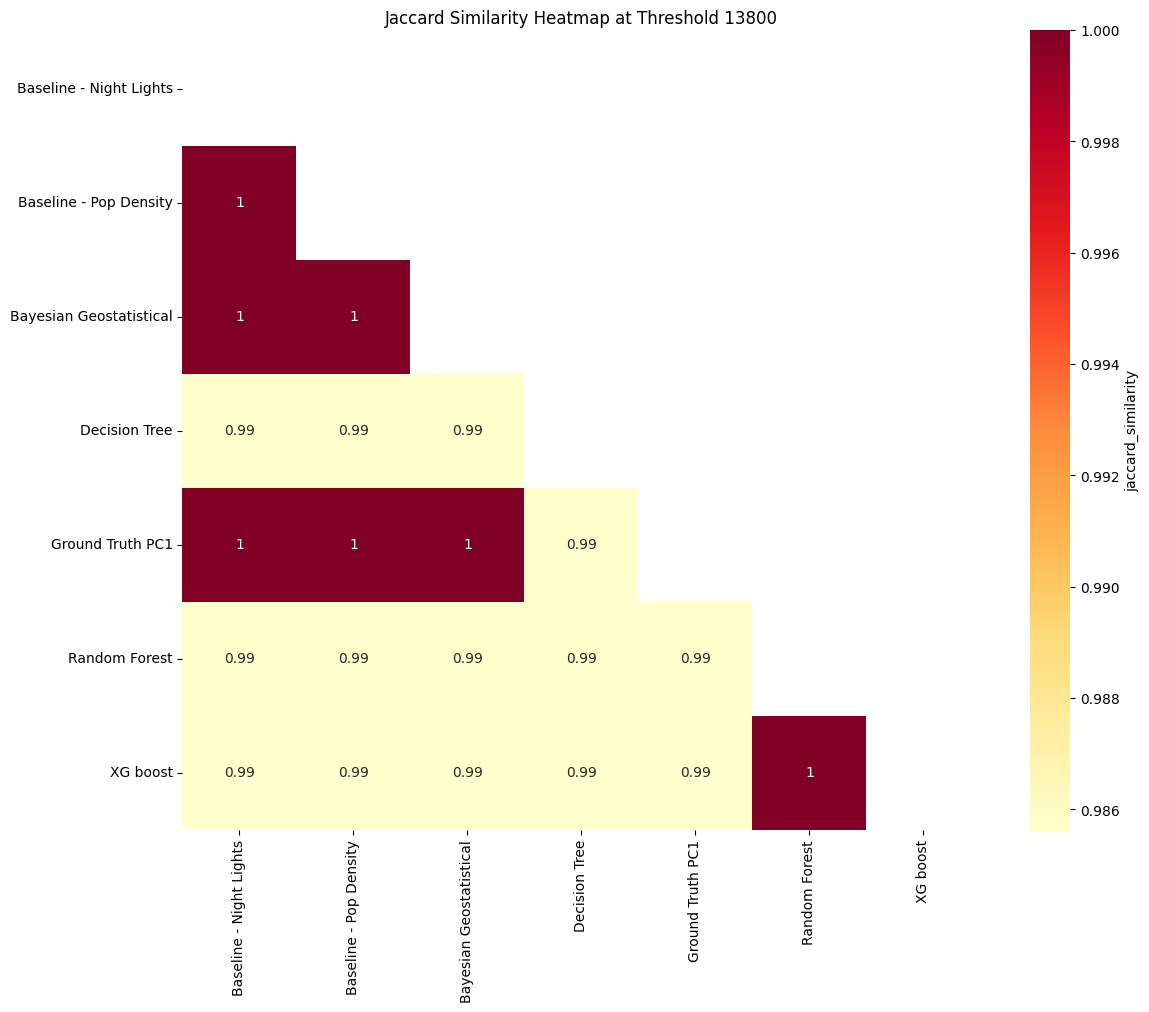

In [426]:
'''
def calculate_overlap(set1, set2):
    return len(set1.intersection(set2)) / min(len(set1), len(set2))

def calculate_jaccard(set1, set2):
    return len(set1.intersection(set2)) / len(set1.union(set2))

def analyze_correlations(df, thresholds):
    model_columns = [col for col in df.columns if col.endswith('_pred_prob_mean')]
    results = []

    for threshold in thresholds:
        threshold_df = df[df['threshold'] <= threshold]
        
        if len(threshold_df) < 1:
            continue
        
        for model1, model2 in combinations(model_columns, 2):
    
            if len(threshold_df[model1]) < 2 or len(threshold_df[model2]) < 2:
                continue
            
            pearson_corr, _ = pearsonr(threshold_df[model1], threshold_df[model2])
            
            k = len(threshold_df)
            top_k_model1 = set(df[model1].nlargest(k).index)
            top_k_model2 = set(df[model2].nlargest(k).index)
            
            overlap = calculate_overlap(top_k_model1, top_k_model2)
            jaccard = calculate_jaccard(top_k_model1, top_k_model2)
            
            results.append({
                'threshold': threshold,
                'model1': model1.replace('_pred_prob_mean', ''),
                'model2': model2.replace('_pred_prob_mean', ''),
                'pearson_correlation': pearson_corr,
                'overlap': overlap,
                'jaccard_similarity': jaccard
            })

    return pd.DataFrame(results)


thresholds_to_analyze = list(range(100, 13801, 100))
correlation_results = analyze_correlations(combined_df, thresholds_to_analyze)
def create_triangular_heatmap(data, metric='pearson_correlation', threshold=None):
    if threshold is None:
        threshold = data['threshold'].max()
    
    threshold_data = data[data['threshold'] == threshold]
    
    models = sorted(set(threshold_data['model1'].unique()) | set(threshold_data['model2'].unique()))
    
    matrix = np.zeros((len(models), len(models)))
    
    for _, row in threshold_data.iterrows():
        i = models.index(row['model1'])
        j = models.index(row['model2'])
        value = row[metric]
        matrix[i, j] = value
        matrix[j, i] = value
    
    mask = np.triu(np.ones_like(matrix, dtype=bool))
    

    plt.figure(figsize=(12, 10))
    sn.heatmap(matrix, mask=mask, annot=True, cmap='YlOrRd', xticklabels=models, yticklabels=models, square=True, cbar_kws={'label': metric})


    
    plt.title(f'{metric.replace("_", " ").title()} Heatmap at Threshold {threshold}')
    plt.tight_layout()
    plt.show()

max_threshold = correlation_results['threshold'].max()
create_triangular_heatmap(correlation_results, 'pearson_correlation', max_threshold)
create_triangular_heatmap(correlation_results, 'overlap', max_threshold)
create_triangular_heatmap(correlation_results, 'jaccard_similarity', max_threshold)


def plot_metric_trends(data, metric):
    plt.figure(figsize=(15, 8))
    for model1, model2 in combinations(data['model1'].unique(), 2):
        model_data = data[(data['model1'] == model1) & (data['model2'] == model2)]
        plt.plot(model_data['threshold'], model_data[metric], label=f'{model1} vs {model2}')
    
    plt.xlabel('Threshold')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f'{metric.replace("_", " ").title()} Trends Across Thresholds')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

#plot_metric_trends(correlation_results, 'pearson_correlation')
#plot_metric_trends(correlation_results, 'overlap')
#lot_metric_trends(correlation_results, 'jaccard_similarity')

'''

In [108]:
correlation_results.to_csv('correlation_results_final_final.csv')

In [230]:
rank_corr_df.to_csv('rank_corr_df.csv')

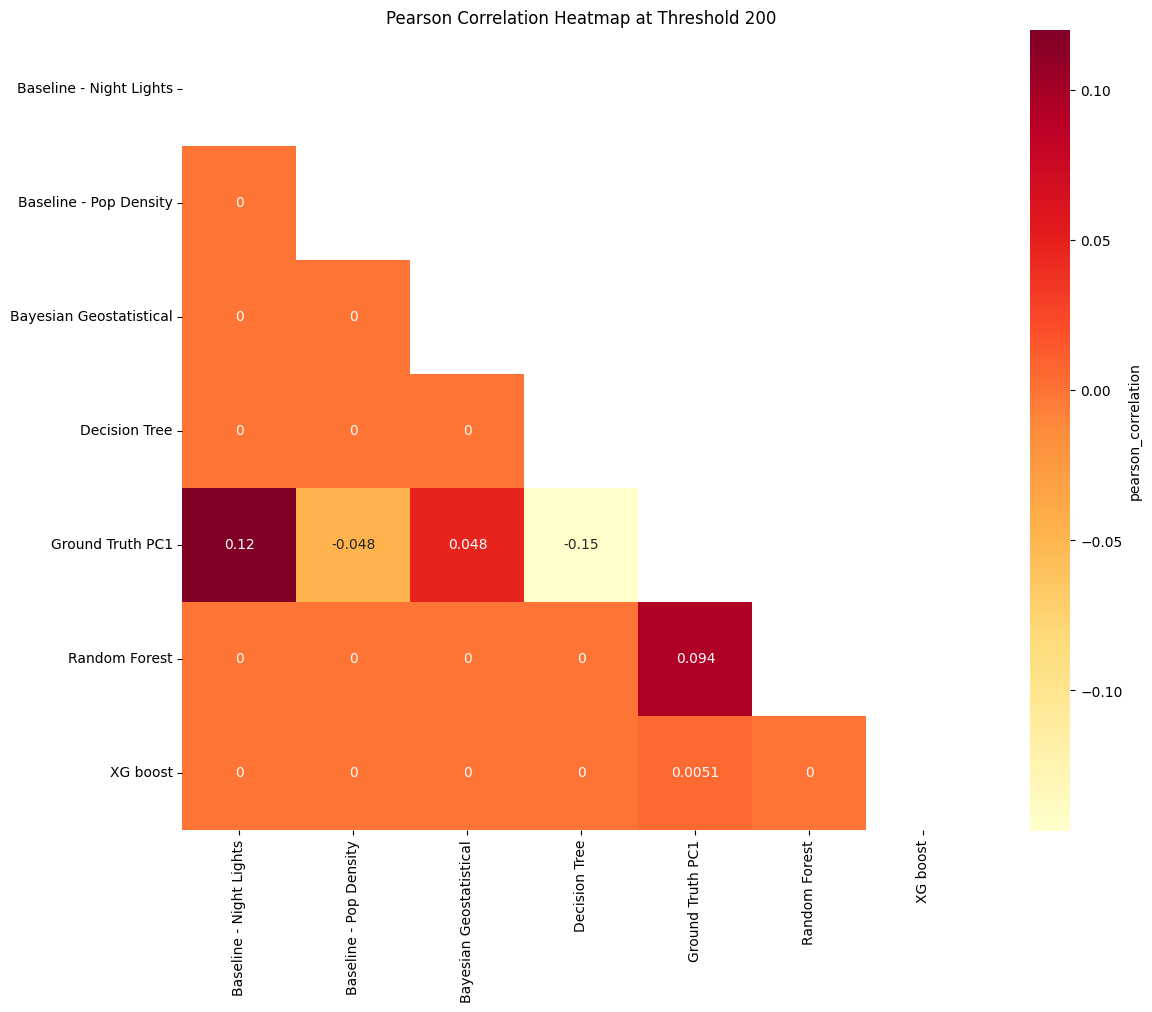

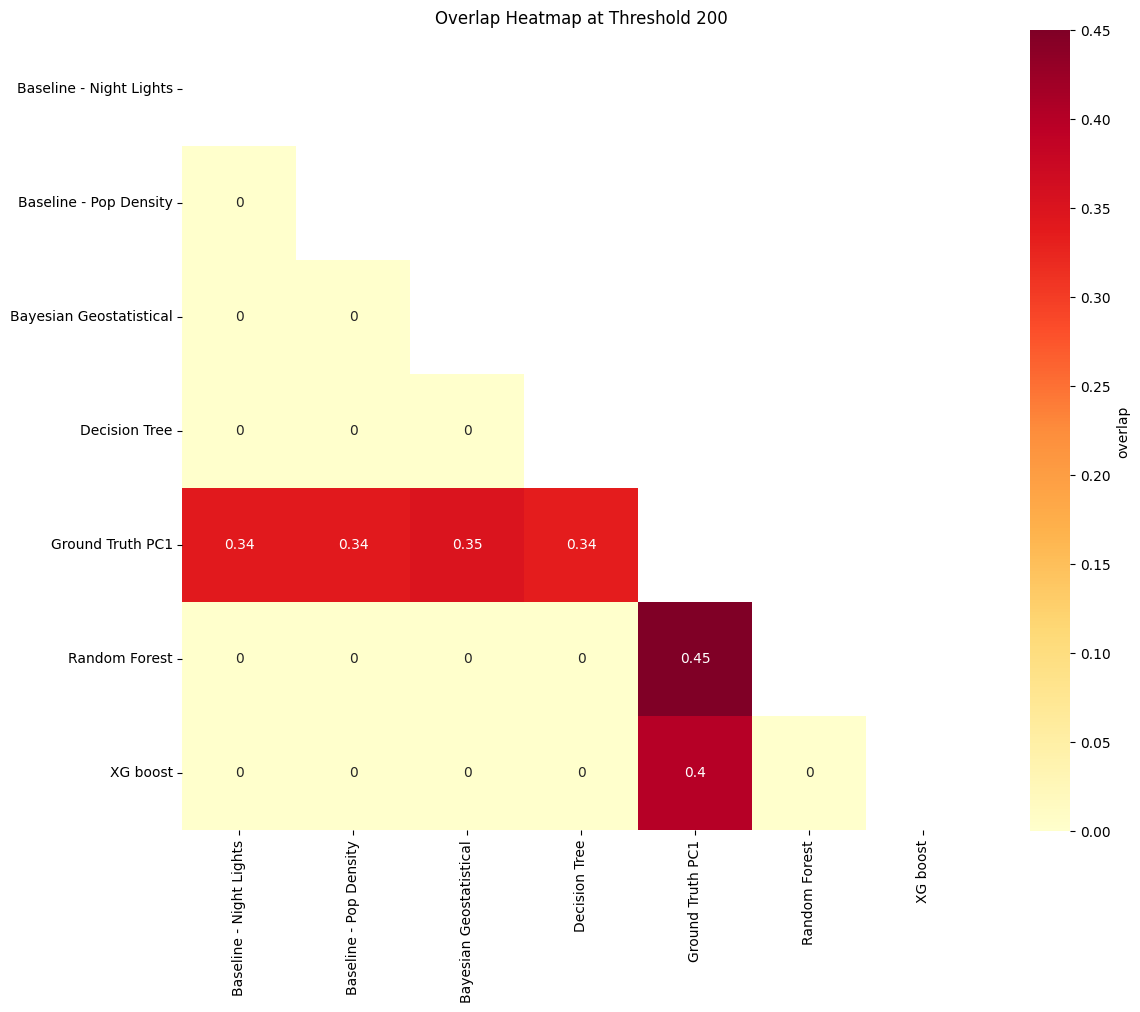

In [427]:
create_triangular_heatmap(pc1, 'pearson_correlation', 200)
create_triangular_heatmap(pc1, 'overlap', 200)

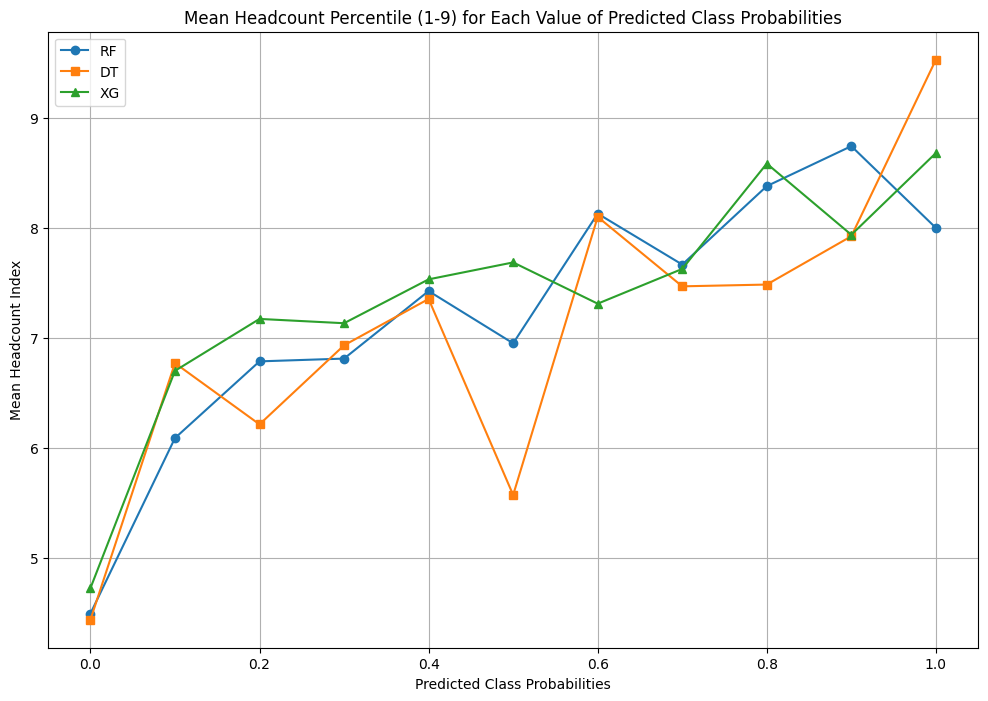

In [479]:

mean_headcount_rf = rf.groupby('pred_prob')['hi_percentiles'].mean().reset_index()
mean_headcount_dt = dt.groupby('pred_prob')['hi_percentiles'].mean().reset_index()
mean_headcount_xg = xg.groupby('pred_prob')['hi_percentiles'].mean().reset_index()

plt.figure(figsize=(12, 8))

plt.plot(mean_headcount_rf['pred_prob'], mean_headcount_rf['hi_percentiles'], marker='o', label='RF')
plt.plot(mean_headcount_dt['pred_prob'], mean_headcount_dt['hi_percentiles'], marker='s', label='DT')
plt.plot(mean_headcount_xg['pred_prob'], mean_headcount_xg['hi_percentiles'], marker='^', label='XG')

plt.title('Mean Headcount Percentile (1-9) for Each Value of Predicted Class Probabilities')
plt.xlabel('Predicted Class Probabilities')
plt.ylabel('Mean Headcount Index')
plt.legend()
plt.grid(True)
plt.show()


/Users/chanukaalgama/Library/CloudStorage/OneDrive-LIRNEasia/DAP PROJECTS/RS + CDR Poverty Mapping/.venv/lib/python3.11/site-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 2.
  self.bins = quantile(y, k=k)


Text(0.5, 1.0, '')

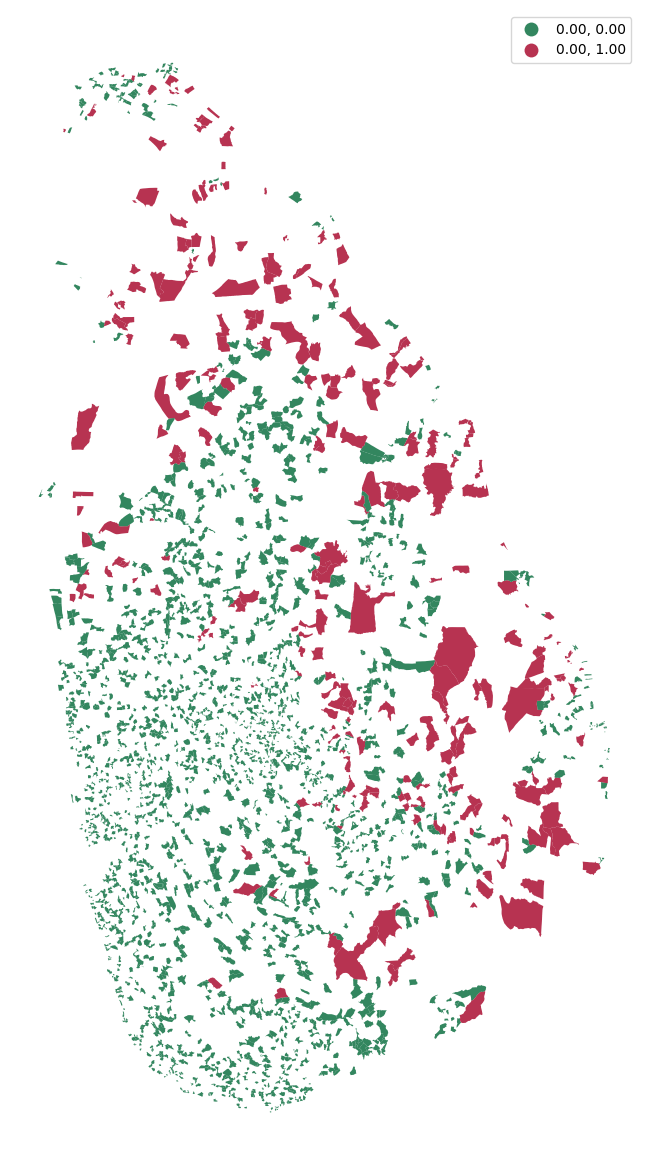

In [498]:
merged = X_test.merge(data_shapefile, left_on=X_test.index, right_on='code_7', how='inner')

gdf = gpd.GeoDataFrame(merged, geometry='geometry', crs=data_shapefile.crs)
gdf = gdf.to_crs(epsg=3857)

fig,ax = plt.subplots(figsize=(15,15))

gdf.plot(ax=ax,
        column='predictions',
        legend=True,
        alpha=0.8,
        cmap='RdYlGn_r',
        scheme='quantiles') 

ax.axis('off')
ax.set_title('',fontsize=22)


KeyError: 'pc1'

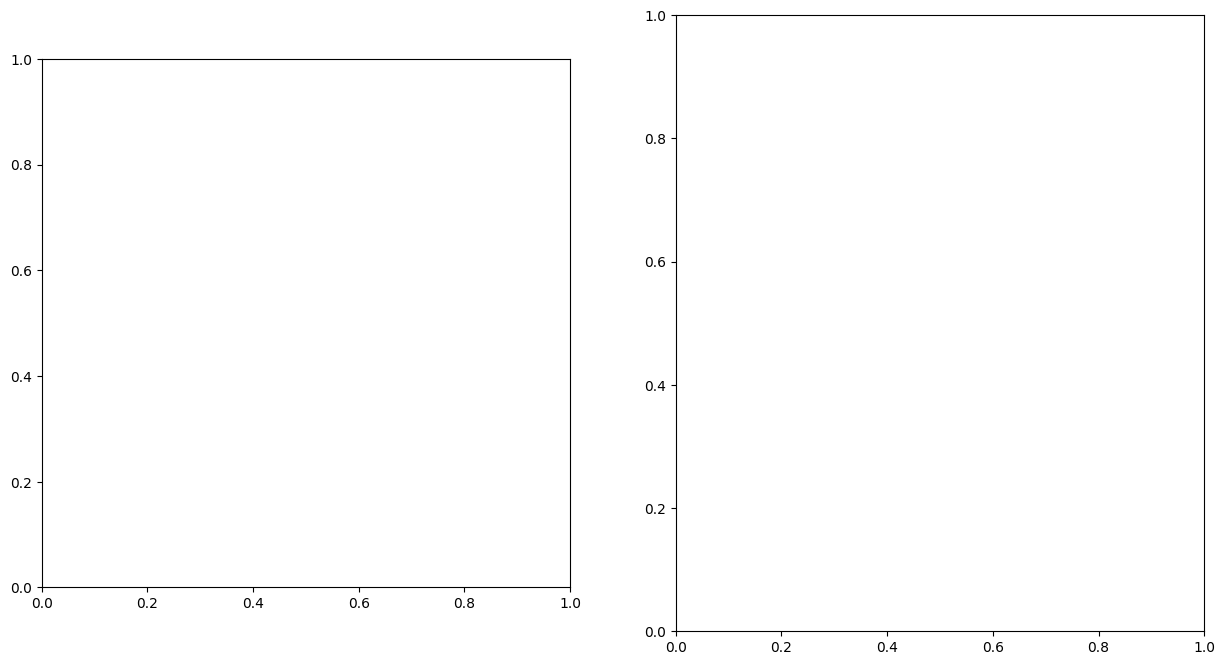

In [499]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# two subplots produces ax[0] (left) and ax[1] (right)

gdf.plot(ax=ax[0],
         column='pc1', 
         cmap='RdYlGn_r', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75, 
           )


ax[0].axis("off")
ax[0].set_title("Ground Truth Map")

gdf.plot(ax=ax[1],
         column='poverty_probability', 
         cmap='RdYlGn_r', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75
           )

ax[1].axis("off")
ax[1].set_title("SDEM Model Map")

plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score

dt_classifier = DecisionTreeClassifier(max_depth=5, random_state=42)
cv_scores = cross_val_score(dt_classifier, X_train, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")
